In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import datetime

from tqdm.notebook import tqdm


import lal
import lalsimulation as lalsim

import pycbc.waveform
import pycbc.pnutils
import pycbc.waveform.utils as wfutils
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import pycbc.types

In [26]:
# np.save("_mtot_grid.npy", mtot_grid)
# np.save("_matches2.npy", matches2)

mtot_grid = np.load("_mtot_grid.npy")
matches2 = np.load("_matches2.npy", allow_pickle=True).flat[0]

In [27]:
# np.save("_mtots.npy", _mtots)
# np.save("_alphas.npy", _alphas)
# np.save("matches_alpha_grid.npy", matches_alpha_grid)

_mtots = np.load("_mtots.npy")
_alphas = np.load("_alphas.npy")
matches_alpha_grid = np.load("matches_alpha_grid.npy")

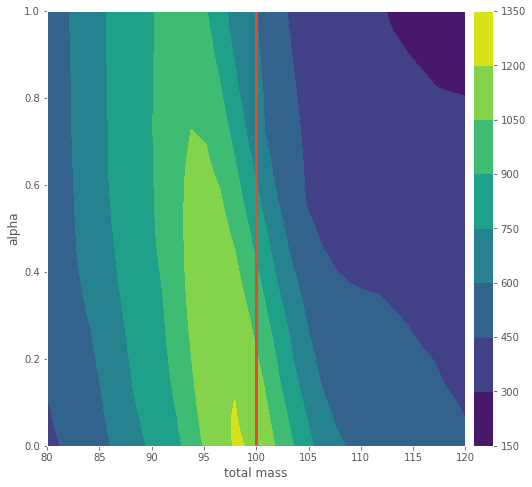

In [28]:
plt.figure(figsize=(8,8))
cs = plt.contourf(_mtots, _alphas, matches_alpha_grid)
plt.xlabel("total mass")
plt.ylabel("alpha")
plt.axvline(100, lw=3)



from mpl_toolkits.axes_grid1 import make_axes_locatable
# https://stackoverflow.com/questions/29516157/set-equal-aspect-in-plot-with-colorbar
the_divider = make_axes_locatable(plt.gca())
color_axis = the_divider.append_axes("right", size="5%", pad=0.1)
# plt.colorbar(cs, ticks=np.linspace(matches.min(), 1, 11), cax=color_axis)
plt.colorbar(cs, cax=color_axis)

In [29]:
# franks scaling idea working well

# res2 = matches_alpha_grid * 0.03448276 #*_alphas
margL = np.exp(matches_alpha_grid-matches_alpha_grid.max()) * 0.03448276 #*_alphas
margL = np.log(margL.sum(axis=0)) + matches_alpha_grid.max()

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [30]:
margL

array([ 528.43994278,  567.08598733,  623.36608376,  688.97203965,
        743.77709849,  787.24671301,  827.28061876,  874.52288761,
        944.35009904, 1017.10816138, 1085.46066392, 1140.53116084,
       1181.19020165, 1204.55252424, 1192.95540966, 1127.70188767,
       1024.97723185,  907.1116071 ,  793.28542624,  696.79317544,
        626.22840081,  581.23423029,  554.73675226,  538.21772654,
        525.12638138,  512.03915483,  498.21376229,  484.39287351,
        474.31098618,          -inf])

In [31]:
# hack the last data point
margL[-1] = margL[-2]

In [32]:
np.median(matches2['IMRPhenomD'])

634.8428474058542

In [33]:
np.quantile(matches2['IMRPhenomD'], 0.5)

634.8428474058542

In [34]:
np.trapz(matches2['IMRPhenomD'], mtot_grid)

29304.339580925487

In [35]:
matches2['IMRPhenomD']*mtot_grid/np.max(matches2['IMRPhenomD'])

array([27.41289196, 30.65911973, 33.53822337, 36.45888533, 40.57429417,
       46.07811835, 51.59718071, 56.20204307, 60.48202974, 66.43134526,
       74.91471101, 84.65506608, 93.10453948, 97.93103448, 98.42239709,
       94.34636568, 86.95278696, 78.02688974, 69.18242516, 61.60294275,
       56.1137766 , 52.77159021, 51.01739794, 50.12619211, 49.51809147,
       48.88003906, 48.1406488 , 47.37358881, 46.71679006, 46.22214707])

In [36]:
np.mean(matches2['IMRPhenomD']*mtot_grid/np.max(matches2['IMRPhenomD']))*np.diff(mtot_grid)[0]

82.08981849436327

In [37]:
np.sum(matches2['IMRPhenomD']*mtot_grid/np.max(matches2['IMRPhenomD']))

1785.4535522524

In [43]:
def expectation(x, y):
    y = np.array(y)
    
    # normalise so that the sum is 1.
    y_norm = y/np.sum(y)
    
    return np.sum(x*y_norm)

In [44]:
expectation(mtot_grid, matches2['IMRPhenomD'])

99.38918221906566

In [45]:
expectation(mtot_grid, matches2['SEOBNRv2'])

96.02660512129208

In [46]:
expectation(mtot_grid, margL)

98.56230195150046

In [169]:
# computing credible intervals or rather HDI
# https://stackoverflow.com/a/22290087/12840171

def errfn(theta, alpha, lb, ub, objective):
    """
    theta: dependent parameter to perform minimisation
    alpha: credible interval
    lb, ub: lower and upper bound for function / integration limits
    objective: callable function for pdf
    
    returns squared error between p(theta) and (1-alpha)
    """
    from scipy import integrate
    def fn( x ):
        pdf = objective(x)
        return pdf if pdf > theta else 0

    prob = integrate.quad(fn, lb, ub)[0]
    return (prob + alpha - 1.0)**2


from scipy.optimize import fmin
from scipy import integrate
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

iy_phend = IUS(mtot_grid, matches2['IMRPhenomD']/np.sum(matches2['IMRPhenomD']))
# iy_phend = IUS(mtot_grid, matches2['IMRPhenomD'])
iy_eobv2 = IUS(mtot_grid, matches2['SEOBNRv2'])
iy_margL = IUS(mtot_grid, margL)


alpha = .1
# alpha = .05
# alpha = .5

p_lower = alpha/2
p_upper = 1-alpha/2

print(f"alpha: {alpha}")
print(f"p_lower: {p_lower}")
print(f"p_upper: {p_upper}")

lb = mtot_grid[0]
ub = mtot_grid[-1]

print(f"lb = {lb}")
print(f"ub = {ub}")

objective = iy_phend

print(integrate.quad(objective, lb, ub))

p_phend = fmin(errfn, x0=100, args=(alpha,lb,ub,objective,))[0]

print(p_phend)

alpha: 0.1
p_lower: 0.05
p_upper: 0.95
lb = 80.0
ub = 120.0
(1.351658969224819, 1.5740345966650905e-08)
Optimization terminated successfully.
         Current function value: 0.810000
         Iterations: 17
         Function evaluations: 50
100.0


In [170]:
res = np.array([(objective(x) + alpha - 1.0)**2 for x in np.linspace(lb, ub, 10000)])

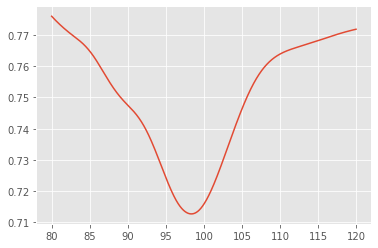

In [171]:
plt.figure()
plt.plot(np.linspace(lb, ub, 10000), res)

In [172]:
np.min(res)

0.7126974696392331

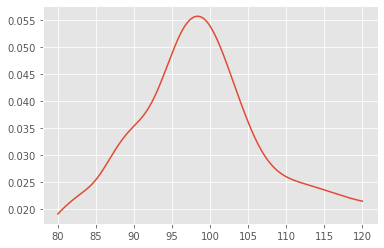

In [164]:
plt.figure()
plt.plot(np.linspace(lb, ub, 1000), objective(np.linspace(lb, ub, 1000)))

Text(0, 0.5, 'likelihood')

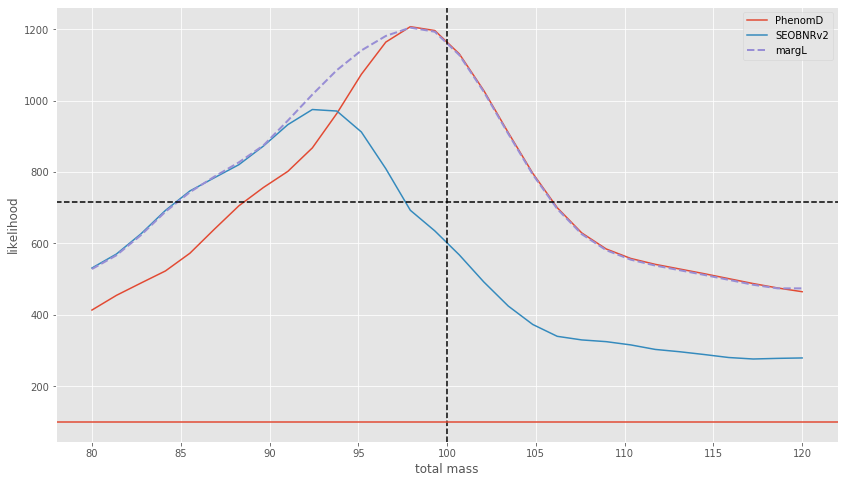

In [139]:
plt.figure(figsize=(14, 8))
plt.plot(mtot_grid, matches2['IMRPhenomD'], label='PhenomD')
plt.plot(mtot_grid, matches2['SEOBNRv2'], label='SEOBNRv2')
# plt.plot(mtot_grid, matches_alpha_grid.sum(axis=0)/len(mtot_grid), label='SEB Marginalised')
plt.plot(mtot_grid, margL, label='margL', lw=2, ls='--')

plt.axvline(100, ls='--', c='k')




# plt.axvline(expectation(mtot_grid, matches2['IMRPhenomD']), c='C0')
# plt.axvline(expectation(mtot_grid, matches2['SEOBNRv2']), c='C1')
# plt.axvline(expectation(mtot_grid, margL), c='C2', ls='--')


plt.axhline(p_phend)


plt.legend()
plt.xlabel("total mass")
plt.ylabel("likelihood")